In [1]:
# Cell 1: Introduction to the Project

"""
# Explainable AI (XAI) for Black-Box Models: A Comparative Analysis

This notebook implements a comprehensive comparison of explainability techniques for deep neural networks. We focus on making opaque models more interpretable using techniques like LIME, SHAP, Saliency Maps, and Anchors.

## Project Goals
1. Evaluate the effectiveness of different XAI methods across datasets and models
2. Develop a benchmark for explanation quality
3. Create a hybrid approach combining multiple explanation techniques
4. Provide extensive analysis and visualizations of results

## Techniques Covered
- LIME (Local Interpretable Model-agnostic Explanations)
- SHAP (SHapley Additive exPlanations)
- Saliency Maps and Integrated Gradients
- Anchors
- Custom hybrid approaches
"""



'\n# Explainable AI (XAI) for Black-Box Models: A Comparative Analysis\n\nThis notebook implements a comprehensive comparison of explainability techniques for deep neural networks. We focus on making opaque models more interpretable using techniques like LIME, SHAP, Saliency Maps, and Anchors.\n\n## Project Goals\n1. Evaluate the effectiveness of different XAI methods across datasets and models\n2. Develop a benchmark for explanation quality\n3. Create a hybrid approach combining multiple explanation techniques\n4. Provide extensive analysis and visualizations of results\n\n## Techniques Covered\n- LIME (Local Interpretable Model-agnostic Explanations)\n- SHAP (SHapley Additive exPlanations)\n- Saliency Maps and Integrated Gradients\n- Anchors\n- Custom hybrid approaches\n'

In [4]:
# Cell 2: Import Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import time
import os
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

# Deep learning libraries
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# XAI libraries
import lime
from lime.lime_tabular import LimeTabularExplainer
from lime.lime_image import LimeImageExplainer
import shap
import eli5
from eli5.sklearn import PermutationImportance
from alibi.explainers import AnchorImage, AnchorTabular
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils import normalize
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus

# For saving models and results
from datetime import datetime
import json

print("All libraries imported successfully!")


All libraries imported successfully!


In [6]:
# Cell 3: Helper Functions

def create_directory(directory):
    """Create directory if it doesn't exist"""
    if not os.path.exists(directory):
        os.makedirs(directory)
        print(f"Created directory: {directory}")
    else:
        print(f"Directory already exists: {directory}")

# Create project directories
base_dir = 'xai_research_project'
create_directory(base_dir)
create_directory(f"{base_dir}/models")
create_directory(f"{base_dir}/results")
create_directory(f"{base_dir}/visualizations")
create_directory(f"{base_dir}/metrics")

def save_dict_to_json(dictionary, filename):
    """Save dictionary to JSON file"""
    with open(filename, 'w') as f:
        json.dump(dictionary, f, indent=4)
    print(f"Saved to {filename}")

def load_dict_from_json(filename):
    """Load dictionary from JSON file"""
    with open(filename, 'r') as f:
        return json.load(f)
    
def save_model(model, model_name):
    """Save Keras model"""
    model.save(f"{base_dir}/models/{model_name}.h5")
    print(f"Model saved to {base_dir}/models/{model_name}.h5")
    
def load_model(model_name):
    """Load Keras model"""
    return tf.keras.models.load_model(f"{base_dir}/models/{model_name}.h5")

def plot_training_history(history, title='Model Training History'):
    """Plot training and validation accuracy/loss"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot training & validation accuracy
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_title(f'{title} - Accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train', 'Validation'], loc='upper left')
    
    # Plot training & validation loss
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title(f'{title} - Loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Validation'], loc='upper left')
    
    plt.tight_layout()
    plt.savefig(f"{base_dir}/visualizations/training_history_{title.replace(' ', '_').lower()}.png")
    plt.show()

Created directory: xai_research_project
Created directory: xai_research_project/models
Created directory: xai_research_project/results
Created directory: xai_research_project/visualizations
Created directory: xai_research_project/metrics


In [7]:
# Cell 4: Loading and Preprocessing MNIST Dataset (You've already started this)

# Load MNIST dataset
mnist = tf.keras.datasets.mnist
(X_train_img, y_train_img), (X_test_img, y_test_img) = mnist.load_data()

# Normalize images and add channel dimension
X_train_img = X_train_img.astype('float32') / 255.0
X_test_img = X_test_img.astype('float32') / 255.0
X_train_img = np.expand_dims(X_train_img, -1)
X_test_img = np.expand_dims(X_test_img, -1)

# One-hot encode labels for classification
y_train_img_cat = to_categorical(y_train_img, 10)
y_test_img_cat = to_categorical(y_test_img, 10)

print("MNIST dataset shape:", X_train_img.shape, X_test_img.shape)

# Create a smaller subset for XAI analysis (explanation can be computationally intensive)
n_samples = 1000
X_test_subset = X_test_img[:n_samples]
y_test_subset = y_test_img[:n_samples]
y_test_subset_cat = y_test_img_cat[:n_samples]

print(f"Test subset shape: {X_test_subset.shape}")

MNIST dataset shape: (60000, 28, 28, 1) (10000, 28, 28, 1)
Test subset shape: (1000, 28, 28, 1)


In [8]:
# Cell 5: Loading Additional Datasets for Comparative Analysis

# Load and prepare Fashion MNIST dataset
fashion_mnist = tf.keras.datasets.fashion_mnist
(X_train_fashion, y_train_fashion), (X_test_fashion, y_test_fashion) = fashion_mnist.load_data()

# Normalize and reshape Fashion MNIST
X_train_fashion = X_train_fashion.astype('float32') / 255.0
X_test_fashion = X_test_fashion.astype('float32') / 255.0
X_train_fashion = np.expand_dims(X_train_fashion, -1)
X_test_fashion = np.expand_dims(X_test_fashion, -1)

# One-hot encode labels
y_train_fashion_cat = to_categorical(y_train_fashion, 10)
y_test_fashion_cat = to_categorical(y_test_fashion, 10)

print("Fashion MNIST dataset shape:", X_train_fashion.shape, X_test_fashion.shape)

# Create a smaller subset for XAI analysis
X_test_fashion_subset = X_test_fashion[:n_samples]
y_test_fashion_subset = y_test_fashion[:n_samples] 
y_test_fashion_subset_cat = y_test_fashion_cat[:n_samples]

# Load CIFAR-10 dataset
cifar10 = tf.keras.datasets.cifar10
(X_train_cifar, y_train_cifar), (X_test_cifar, y_test_cifar) = cifar10.load_data()

# Normalize CIFAR-10
X_train_cifar = X_train_cifar.astype('float32') / 255.0
X_test_cifar = X_test_cifar.astype('float32') / 255.0

# One-hot encode labels (flatten y arrays first if needed)
y_train_cifar = y_train_cifar.reshape(-1)
y_test_cifar = y_test_cifar.reshape(-1)
y_train_cifar_cat = to_categorical(y_train_cifar, 10)
y_test_cifar_cat = to_categorical(y_test_cifar, 10)

print("CIFAR-10 dataset shape:", X_train_cifar.shape, X_test_cifar.shape)

# Create a smaller subset for XAI analysis
X_test_cifar_subset = X_test_cifar[:n_samples]
y_test_cifar_subset = y_test_cifar[:n_samples]
y_test_cifar_subset_cat = y_test_cifar_cat[:n_samples]

# Mapping of class labels for each dataset
mnist_class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

fashion_class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
                      'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

cifar10_class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer',
                      'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

# Create dataset dictionary for easier handling
datasets = {
    "MNIST": {
        "X_train": X_train_img,
        "y_train": y_train_img,
        "y_train_cat": y_train_img_cat,
        "X_test": X_test_img,
        "y_test": y_test_img,
        "y_test_cat": y_test_img_cat,
        "X_test_subset": X_test_subset,
        "y_test_subset": y_test_subset,
        "y_test_subset_cat": y_test_subset_cat,
        "class_names": mnist_class_names,
        "input_shape": X_train_img.shape[1:],
        "channels": 1
    },
    "Fashion-MNIST": {
        "X_train": X_train_fashion,
        "y_train": y_train_fashion,
        "y_train_cat": y_train_fashion_cat,
        "X_test": X_test_fashion,
        "y_test": y_test_fashion,
        "y_test_cat": y_test_fashion_cat,
        "X_test_subset": X_test_fashion_subset,
        "y_test_subset": y_test_fashion_subset,
        "y_test_subset_cat": y_test_fashion_subset_cat,
        "class_names": fashion_class_names,
        "input_shape": X_train_fashion.shape[1:],
        "channels": 1
    },
    "CIFAR-10": {
        "X_train": X_train_cifar,
        "y_train": y_train_cifar,
        "y_train_cat": y_train_cifar_cat,
        "X_test": X_test_cifar,
        "y_test": y_test_cifar,
        "y_test_cat": y_test_cifar_cat,
        "X_test_subset": X_test_cifar_subset,
        "y_test_subset": y_test_cifar_subset,
        "y_test_subset_cat": y_test_cifar_subset_cat,
        "class_names": cifar10_class_names,
        "input_shape": X_train_cifar.shape[1:],
        "channels": 3
    }
}

# Display dataset details
for name, data in datasets.items():
    print(f"\n{name} Dataset Summary:")
    print(f"  Training samples: {data['X_train'].shape[0]}")
    print(f"  Test samples: {data['X_test'].shape[0]}")
    print(f"  Input shape: {data['input_shape']}")
    print(f"  Classes: {data['class_names']}")

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 2us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Fashion MNIST dataset shape: (60000, 28, 28, 1) (10000, 28, 28, 1)
170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 45s 0us/step
CIFAR-10 dataset shape: (50000, 32, 32, 3) (10000, 32, 32, 3)

MNIST Dataset Summary:
  Training samples: 60000
  Test samples: 10000
  Input shape: (28, 28, 1)
  Classes: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

Fashion-MNIST Dataset Summary:
  Training samples: 60000
  Test samples: 10000
  Input shape: (28, 28, 1)
  Classes: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

CIFAR-10 Dataset Summary:
  Training samples: 50000
  Test samples: 10000
  Input shape: (32, 32, 3)
  Classes: ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']


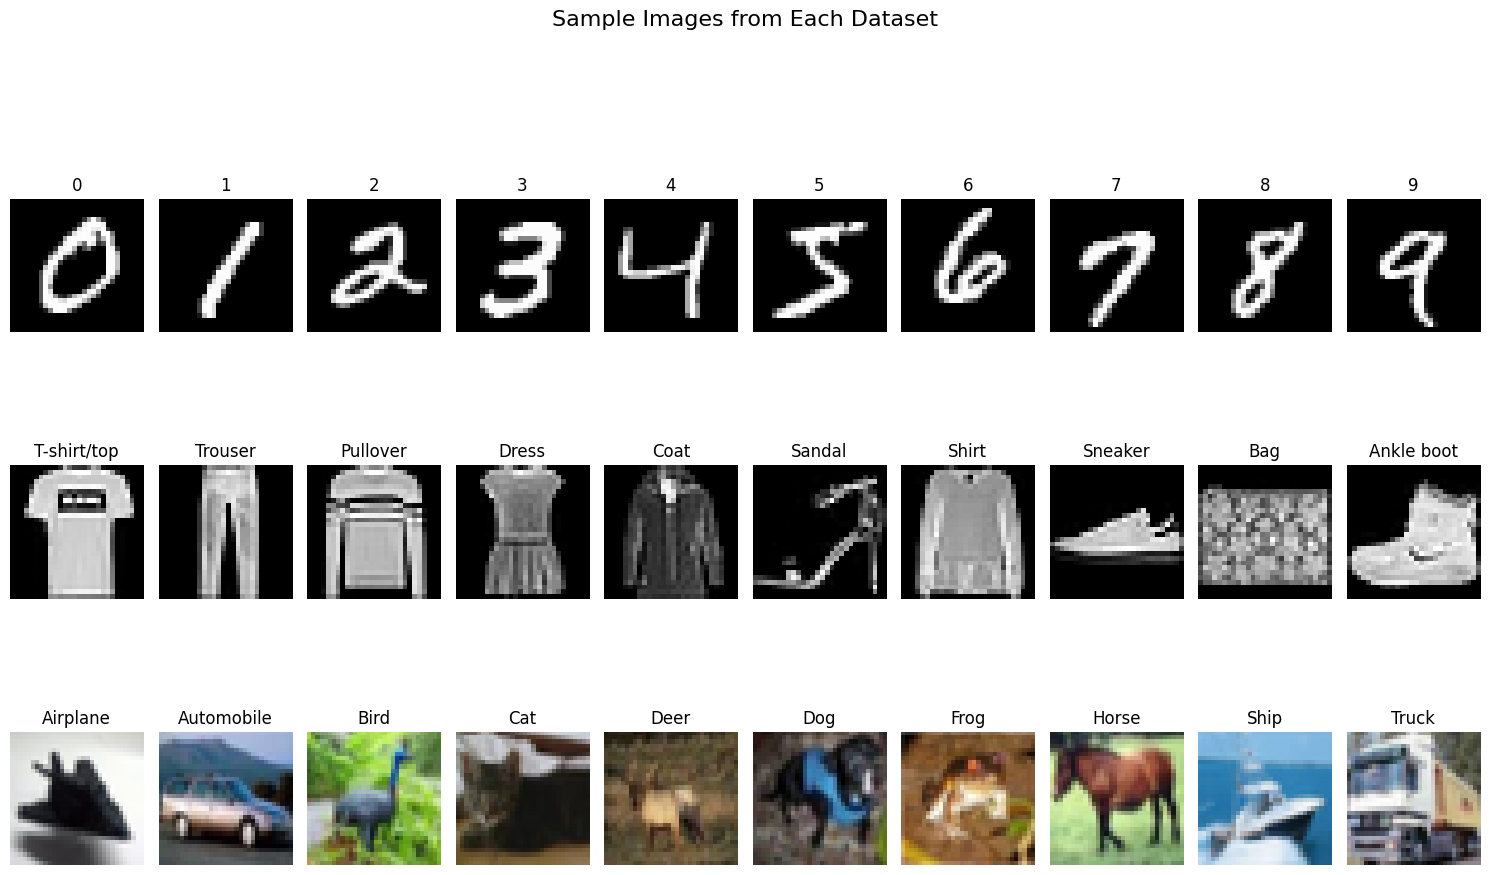

In [9]:
# Cell 6: Visualize Sample Images from Each Dataset

plt.figure(figsize=(15, 10))

# MNIST
for i in range(10):
    plt.subplot(3, 10, i+1)
    plt.imshow(X_train_img[y_train_img == i][0].reshape(28, 28), cmap='gray')
    plt.title(mnist_class_names[i])
    plt.axis('off')

# Fashion MNIST
for i in range(10):
    plt.subplot(3, 10, i+11)
    plt.imshow(X_train_fashion[y_train_fashion == i][0].reshape(28, 28), cmap='gray')
    plt.title(fashion_class_names[i])
    plt.axis('off')

# CIFAR-10
for i in range(10):
    plt.subplot(3, 10, i+21)
    idx = np.where(y_train_cifar == i)[0][0]
    plt.imshow(X_train_cifar[idx])
    plt.title(cifar10_class_names[i])
    plt.axis('off')

plt.suptitle("Sample Images from Each Dataset", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.savefig(f"{base_dir}/visualizations/dataset_samples.png")
plt.show()

In [10]:
# Cell 7: Model Building Functions

def build_mnist_model():
    """Build a simple CNN for MNIST/Fashion-MNIST"""
    model = models.Sequential()
    model.add(layers.Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(28, 28, 1)))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    model.add(layers.Conv2D(64, (3,3), activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def build_cifar_model():
    """Build a CNN for CIFAR-10"""
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.2),
        
        layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.3),
        
        layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.4),
        
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(10, activation='softmax')
    ])
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Define a function to build, train and evaluate models for each dataset
def build_train_evaluate_model(dataset_name, epochs=10, batch_size=128):
    """Build, train and evaluate a model for the given dataset"""
    print(f"Processing {dataset_name} dataset...")
    data = datasets[dataset_name]
    
    # Choose the appropriate model architecture
    if dataset_name in ["MNIST", "Fashion-MNIST"]:
        model = build_mnist_model()
    else:  # CIFAR-10
        model = build_cifar_model()
    
    # Train the model
    history = model.fit(
        data["X_train"], data["y_train_cat"],
        batch_size=batch_size,
        epochs=epochs,
        validation_split=0.1,
        verbose=1
    )
    
    # Evaluate the model
    test_loss, test_acc = model.evaluate(data["X_test"], data["y_test_cat"], verbose=0)
    print(f"{dataset_name} model accuracy: {test_acc:.4f}")
    
    # Plot training history
    plot_training_history(history, title=f"{dataset_name} Model")
    
    # Save the model
    save_model(model, f"{dataset_name.lower().replace('-', '_')}_model")
    
    # Save the training history
    history_dict = {key: [float(val) for val in history.history[key]] for key in history.history.keys()}
    save_dict_to_json(history_dict, f"{base_dir}/results/{dataset_name.lower().replace('-', '_')}_history.json")
    
    return model, history

Processing MNIST dataset...


E:\Source Codes\AIML\final_year_paper\myenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - accuracy: 0.8437 - loss: 0.5415 - val_accuracy: 0.9835 - val_loss: 0.0627
Epoch 2/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - accuracy: 0.9789 - loss: 0.0675 - val_accuracy: 0.9868 - val_loss: 0.0469
Epoch 3/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - accuracy: 0.9872 - loss: 0.0407 - val_accuracy: 0.9893 - val_loss: 0.0383
Epoch 4/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - accuracy: 0.9892 - loss: 0.0337 - val_accuracy: 0.9880 - val_loss: 0.0407
Epoch 5/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - accuracy: 0.9920 - loss: 0.0245 - val_accuracy: 0.9897 - val_loss: 0.0414
MNIST model accuracy: 0.9880


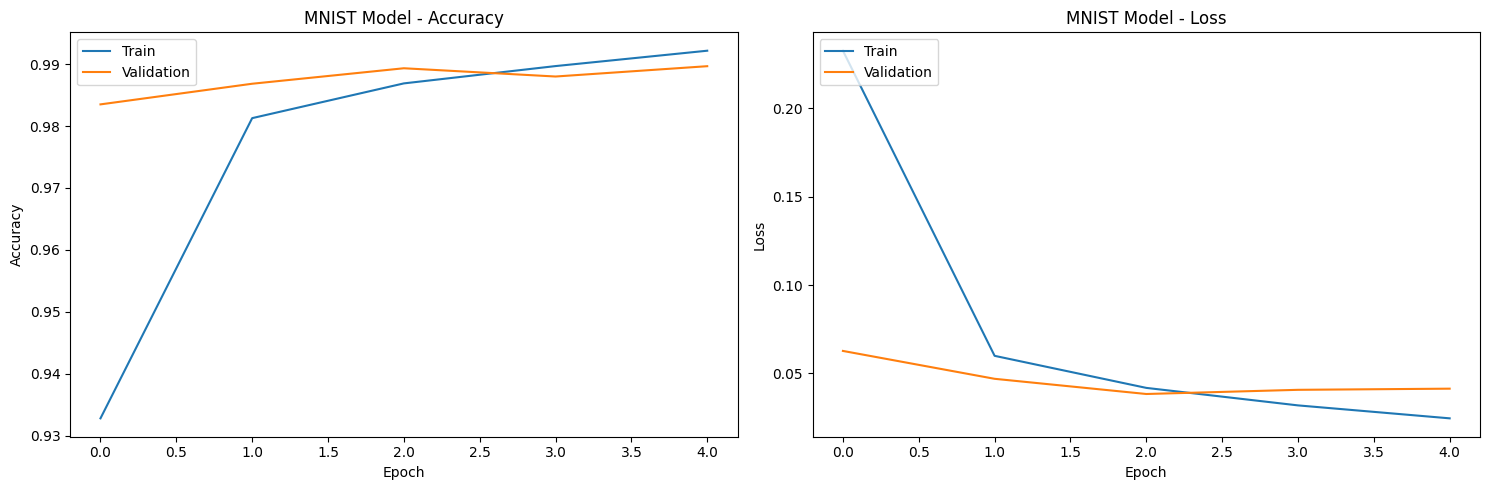

Model saved to xai_research_project/models/mnist_model.h5
Saved to xai_research_project/results/mnist_history.json
Processing Fashion-MNIST dataset...
Epoch 1/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - accuracy: 0.7193 - loss: 0.8129 - val_accuracy: 0.8618 - val_loss: 0.3822
Epoch 2/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - accuracy: 0.8699 - loss: 0.3614 - val_accuracy: 0.8797 - val_loss: 0.3247
Epoch 3/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - accuracy: 0.8852 - loss: 0.3136 - val_accuracy: 0.8888 - val_loss: 0.2960
Epoch 4/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 14s 32ms/step - accuracy: 0.8988 - loss: 0.2810 - val_accuracy: 0.8892 - val_loss: 0.2918
Epoch 5/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 19s 28ms/step - accuracy: 0.9063 - loss: 0.2578 - val_accuracy: 0.9023 - val_loss: 0.2649
Fashion-MNIST model accuracy: 0.8980


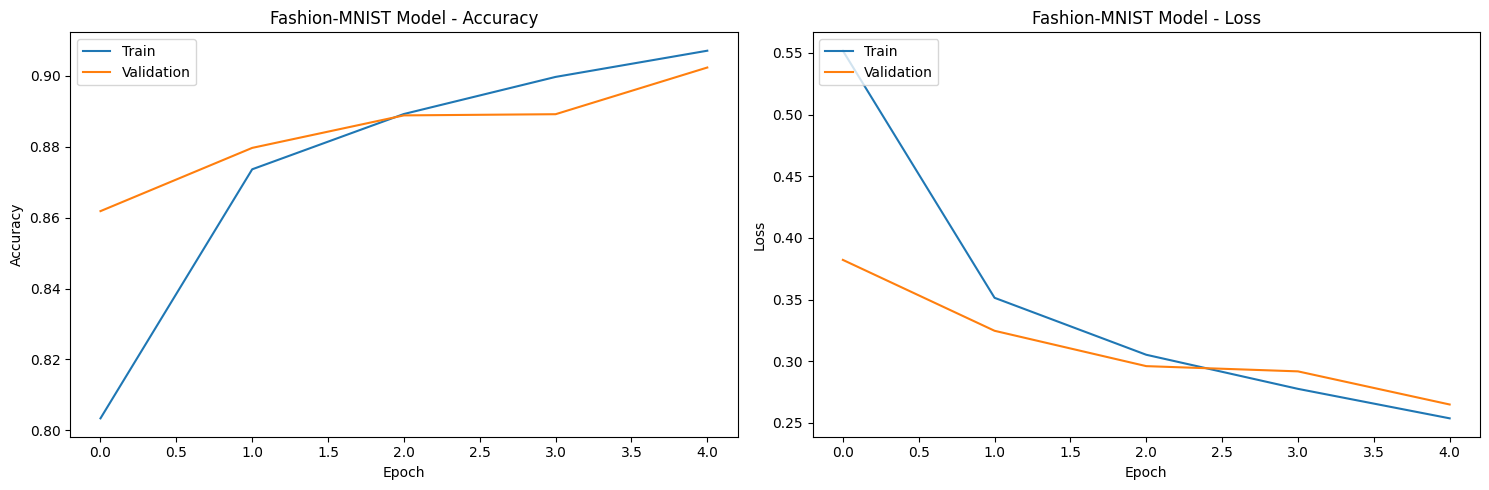

Model saved to xai_research_project/models/fashion_mnist_model.h5
Saved to xai_research_project/results/fashion_mnist_history.json
Processing CIFAR-10 dataset...
Epoch 1/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 172s 473ms/step - accuracy: 0.3175 - loss: 2.1764 - val_accuracy: 0.2030 - val_loss: 2.9175
Epoch 2/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 159s 451ms/step - accuracy: 0.5680 - loss: 1.2195 - val_accuracy: 0.6230 - val_loss: 1.0788
Epoch 3/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 152s 432ms/step - accuracy: 0.6550 - loss: 0.9807 - val_accuracy: 0.7162 - val_loss: 0.7860
Epoch 4/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 217s 476ms/step - accuracy: 0.7103 - loss: 0.8303 - val_accuracy: 0.7280 - val_loss: 0.7790
Epoch 5/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 163s 464ms/step - accuracy: 0.7308 - loss: 0.7687 - val_accuracy: 0.7228 - val_loss: 0.7918
Epoch 6/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 189s 428ms/step - accuracy: 0.7566 - loss: 0.6931 - val_accuracy: 0.7670 - val_loss: 0.6769
Epoch 7/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 201s 4

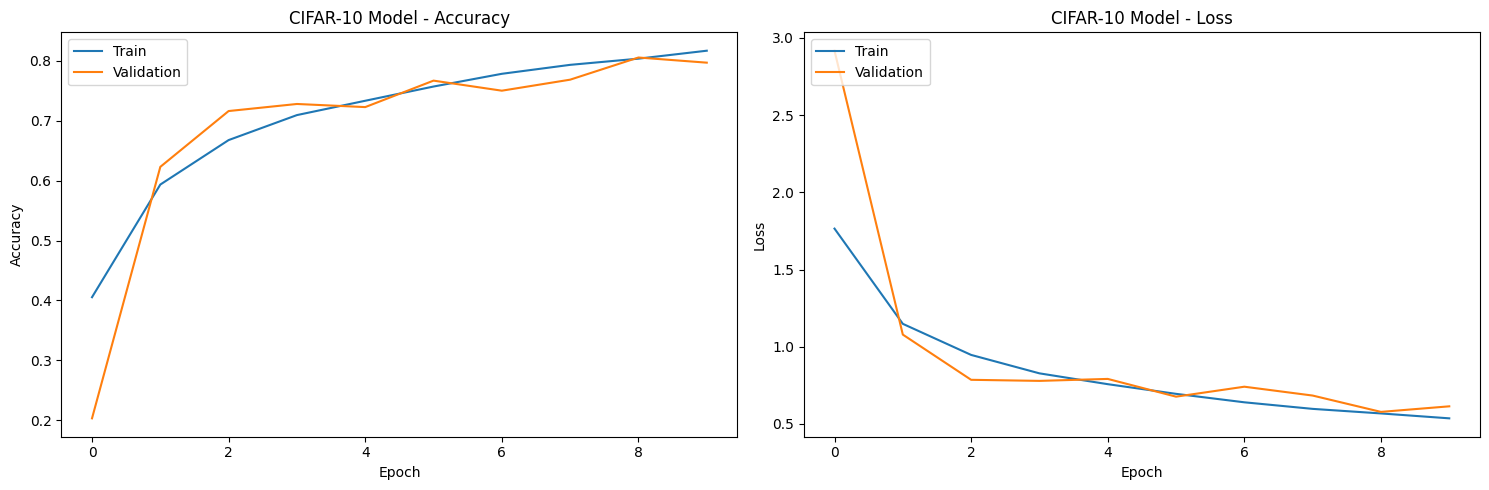

Model saved to xai_research_project/models/cifar_10_model.h5
Saved to xai_research_project/results/cifar_10_history.json
All models trained successfully!


In [11]:
# Cell 8: Train Models for Each Dataset
# Note: This cell might take a long time to run. You can reduce epochs for faster execution.

# Dictionary to store trained models
trained_models = {}

# Train MNIST model (you've already started training this)
if 'mnist_model' in globals():
    print("MNIST model already trained. Using existing model.")
    trained_models["MNIST"] = mnist_model
    # Save the model if not already saved
    save_model(mnist_model, "mnist_model")
else:
    mnist_model, mnist_history = build_train_evaluate_model("MNIST", epochs=5)
    trained_models["MNIST"] = mnist_model

# Train Fashion-MNIST model
fashion_model, fashion_history = build_train_evaluate_model("Fashion-MNIST", epochs=5)
trained_models["Fashion-MNIST"] = fashion_model

# Train CIFAR-10 model
cifar_model, cifar_history = build_train_evaluate_model("CIFAR-10", epochs=10)
trained_models["CIFAR-10"] = cifar_model

print("All models trained successfully!")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

MNIST Model Evaluation:
  Accuracy: 0.9880


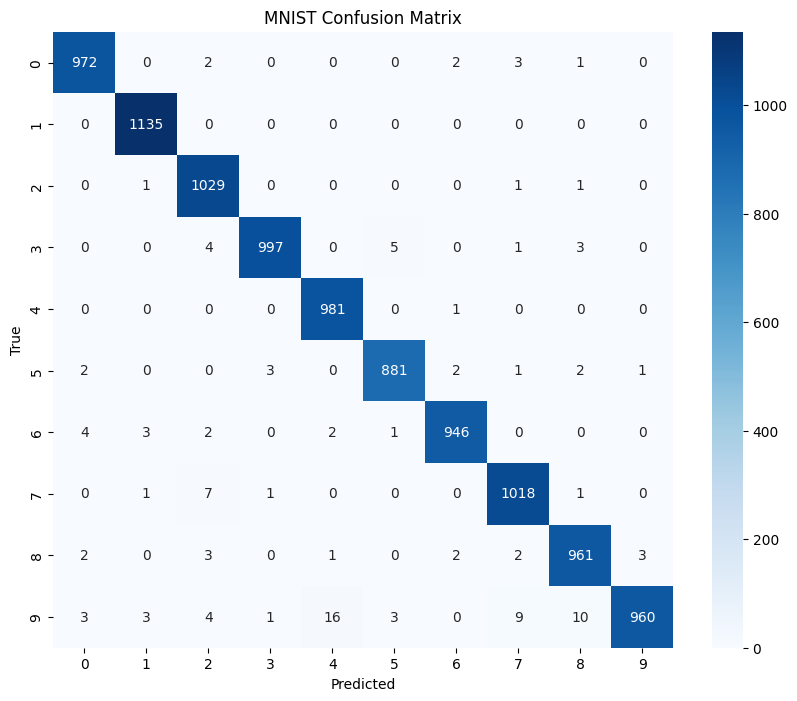

Saved to xai_research_project/results/mnist_predictions.json
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Fashion-MNIST Model Evaluation:
  Accuracy: 0.8980


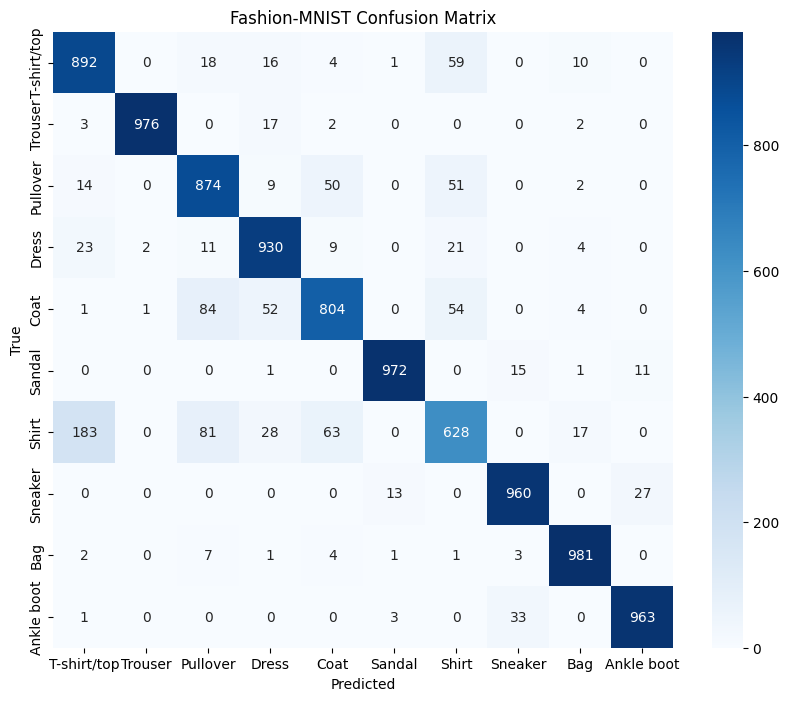

Saved to xai_research_project/results/fashion_mnist_predictions.json
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step

CIFAR-10 Model Evaluation:
  Accuracy: 0.7890


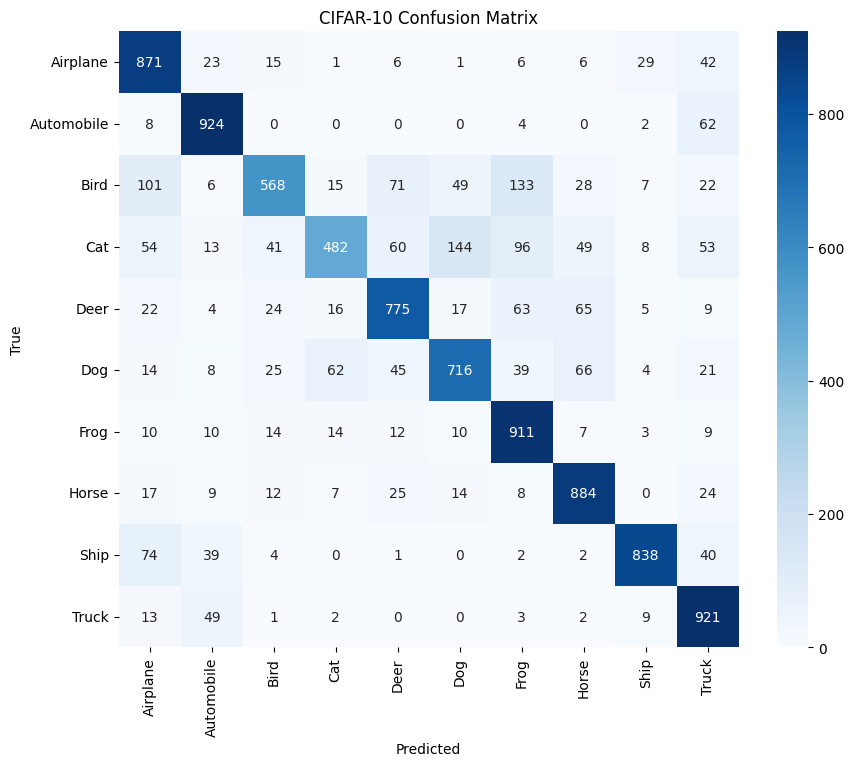

Saved to xai_research_project/results/cifar_10_predictions.json
Model evaluation completed and predictions saved!


In [12]:
# Cell 9: Evaluate Models and Save Predictions

# Dictionary to store predictions
predictions = {}

for dataset_name, model in trained_models.items():
    data = datasets[dataset_name]
    
    # Get predictions for test set
    y_pred_prob = model.predict(data["X_test"])
    y_pred = np.argmax(y_pred_prob, axis=1)
    
    # Get predictions for subset (used for XAI)
    y_subset_pred_prob = model.predict(data["X_test_subset"])
    y_subset_pred = np.argmax(y_subset_pred_prob, axis=1)
    
    # Store predictions
    predictions[dataset_name] = {
        "full_probs": y_pred_prob.tolist(),  # Convert to list for JSON serialization
        "full_preds": y_pred.tolist(),
        "subset_probs": y_subset_pred_prob.tolist(),
        "subset_preds": y_subset_pred.tolist()
    }
    
    # Calculate and display metrics
    accuracy = accuracy_score(data["y_test"], y_pred)
    print(f"\n{dataset_name} Model Evaluation:")
    print(f"  Accuracy: {accuracy:.4f}")
    
    # Generate and display confusion matrix
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(data["y_test"], y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=data["class_names"], 
                yticklabels=data["class_names"])
    plt.title(f"{dataset_name} Confusion Matrix")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(f"{base_dir}/visualizations/{dataset_name.lower().replace('-', '_')}_confusion_matrix.png")
    plt.show()
    
    # Save predictions
    save_dict_to_json(
        {"predictions": predictions[dataset_name]}, 
        f"{base_dir}/results/{dataset_name.lower().replace('-', '_')}_predictions.json"
    )

print("Model evaluation completed and predictions saved!")

In [13]:
# Cell 10: Define XAI Helper Functions

# Define a function to preprocess images for explanations
def preprocess_image_for_explanation(image, dataset_name):
    """Preprocess image based on dataset type"""
    if dataset_name in ["MNIST", "Fashion-MNIST"]:
        # For single channel images, remove the channel dimension
        if image.shape[-1] == 1:
            return image.reshape(image.shape[:-1])
        return image
    else:  # For CIFAR-10 and other RGB images
        return image

# Define a function to display explanations side by side with original images
def plot_explanation_comparison(original_images, explanations, true_labels, predicted_labels, 
                               class_names, title, filename=None, explanation_type="heatmap",
                               cmap="seismic", alpha=0.6):
    """
    Plot original images alongside their explanations
    
    Parameters:
    - original_images: List of original images
    - explanations: List of explanation heatmaps/masks
    - true_labels: List of true class labels
    - predicted_labels: List of predicted class labels
    - class_names: List of class names
    - title: Title for the plot
    - filename: Filename to save the plot
    - explanation_type: Type of explanation visualization ("heatmap", "mask", "overlay")
    - cmap: Colormap for heatmap
    - alpha: Transparency for overlays
    """
    n_images = len(original_images)
    fig, axes = plt.subplots(n_images, 2, figsize=(12, 3*n_images))
    
    if n_images == 1:
        axes = axes.reshape(1, -1)
    
    for i in range(n_images):
        # Original image
        img = original_images[i]
        if len(img.shape) == 3 and img.shape[-1] == 1:
            # MNIST/Fashion-MNIST (grayscale)
            axes[i, 0].imshow(img.reshape(img.shape[:-1]), cmap='gray')
        else:
            # CIFAR-10 (RGB)
            axes[i, 0].imshow(img)
            
        axes[i, 0].set_title(f"Original Image\nTrue: {class_names[true_labels[i]]}\nPredicted: {class_names[predicted_labels[i]]}")
        axes[i, 0].axis('off')
        
        # Explanation
        expl = explanations[i]
        if explanation_type == "heatmap":
            axes[i, 1].imshow(expl, cmap=cmap)
        elif explanation_type == "mask":
            if len(img.shape) == 3 and img.shape[-1] == 1:
                # Grayscale
                axes[i, 1].imshow(expl, cmap='gray')
            else:
                # RGB
                axes[i, 1].imshow(expl)
        elif explanation_type == "overlay":
            if len(img.shape) == 3 and img.shape[-1] == 1:
                # Grayscale
                base_img = img.reshape(img.shape[:-1])
                axes[i, 1].imshow(base_img, cmap='gray')
                axes[i, 1].imshow(expl, cmap=cmap, alpha=alpha)
            else:
                # RGB
                axes[i, 1].imshow(img)
                axes[i, 1].imshow(expl, cmap=cmap, alpha=alpha)
        
        axes[i, 1].set_title(f"{title} Explanation")
        axes[i, 1].axis('off')
    
    plt.tight_layout()
    
    if filename:
        plt.savefig(filename)
    
    plt.show()

# Define a function to create evaluation metrics for explanations
def evaluate_explanation_quality(explanation, image, model, pred_class, metrics=None):
    """
    Evaluate the quality of an explanation
    
    Parameters:
    - explanation: The explanation (heatmap, mask, etc.)
    - image: Original image
    - model: Trained model
    - pred_class: Predicted class
    - metrics: List of metrics to compute (options: 'sparsity', 'fidelity')
    
    Returns:
    - Dictionary of metric values
    """
    if metrics is None:
        metrics = ['sparsity', 'fidelity']
    
    results = {}
    
    # Sparsity: measure of how focused the explanation is (lower is more focused)
    if 'sparsity' in metrics:
        # Normalize explanation to [0, 1] range if not already
        if explanation.min() < 0 or explanation.max() > 1:
            norm_exp = (explanation - explanation.min()) / (explanation.max() - explanation.min())
        else:
            norm_exp = explanation
            
        # Calculate sparsity as the fraction of the explanation that is activated
        threshold = 0.2  # Consider only top 20% of importance values
        sparsity = np.mean(norm_exp > threshold)
        results['sparsity'] = float(sparsity)
    
    # Fidelity: measure how much the prediction changes when important features are removed
    if 'fidelity' in metrics:
        # This is a simplified version - actual implementation would vary by XAI method
        # For demonstration purposes, we'll use a simple mask-based approach
        try:
            # Create a copy of the image
            masked_image = image.copy()
            
            # Normalize explanation to [0, 1] range if not already
            if explanation.min() < 0 or explanation.max() > 1:
                norm_exp = (explanation - explanation.min()) / (explanation.max() - explanation.min())
            else:
                norm_exp = explanation
                
            # Create a mask that zeroes out important features
            mask = norm_exp < 0.5  # Keep only less important features
            
            # Apply mask to image
            if len(image.shape) == 3 and image.shape[-1] == 1:  # Grayscale
                masked_image = masked_image * mask.reshape(*mask.shape, 1)
            elif len(image.shape) == 3 and image.shape[-1] == 3:  # RGB
                # Resize mask if needed
                if mask.shape != image.shape[:2]:
                    from skimage.transform import resize
                    mask = resize(mask, image.shape[:2], preserve_range=True)
                masked_image = masked_image * mask.reshape(*mask.shape, 1)
            
            # Get prediction on masked image
            masked_pred = model.predict(np.expand_dims(masked_image, axis=0))[0]
            original_pred = model.predict(np.expand_dims(image, axis=0))[0]
            
            # Calculate fidelity as the change in prediction probability
            fidelity = original_pred[pred_class] - masked_pred[pred_class]
            results['fidelity'] = float(fidelity)
        except Exception as e:
            print(f"Error calculating fidelity: {e}")
            results['fidelity'] = None
    
    return results

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Generating LIME explanations for MNIST...
Processing image 1/5...


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━

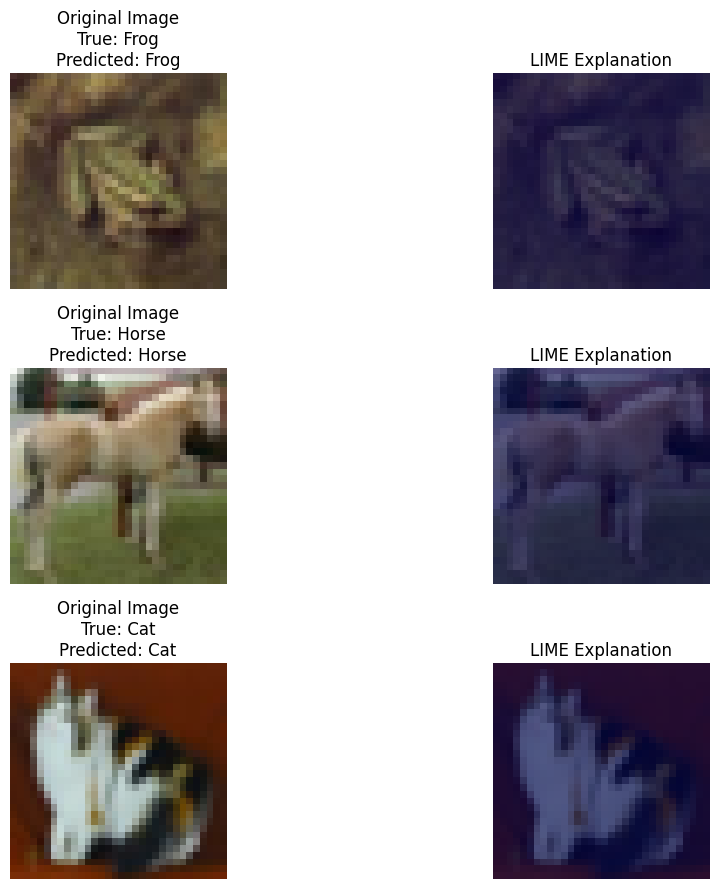

Saved to xai_research_project/metrics/cifar_10_lime_metrics.json
LIME analysis completed!


In [15]:
def apply_lime_to_image(model, image, dataset_name, num_samples=1000, num_features=100):
    """
    Apply LIME explainer to an image
    
    Parameters:
    - model: Trained model
    - image: Image to explain
    - dataset_name: Name of the dataset
    - num_samples: Number of perturbed samples for LIME
    - num_features: Number of features (superpixels) for LIME
    
    Returns:
    - explanation: LIME explanation object
    - exp_image: Visual explanation (heatmap)
    """
    # Create explainer
    explainer = LimeImageExplainer()
    
    # Format input for explanation
    if dataset_name in ["MNIST", "Fashion-MNIST"]:
        exp_image = np.reshape(image, (28, 28))  # Remove channel dimension
    else:  # CIFAR-10
        exp_image = image
    
    # Define a proper classifier function that returns probabilities in the correct shape
    def classifier_fn(x):
        # Ensure x is properly shaped for the model
        reshaped_x = np.array(x).reshape(-1, *image.shape)
        return model.predict(reshaped_x)
    
    # Get explanation
    explanation = explainer.explain_instance(
        exp_image, 
        classifier_fn=classifier_fn,
        top_labels=5,
        num_samples=num_samples,
        num_features=num_features
    )
    
    # Get heatmap
    pred_class = np.argmax(model.predict(np.expand_dims(image, axis=0))[0])
    _, heatmap = explanation.get_image_and_mask(
        pred_class,  # Use the predicted class instead of explanation.top_labels[0]
        positive_only=True, 
        num_features=num_features,
        hide_rest=False
    )
    
    return explanation, heatmap

def analyze_images_with_lime(model, dataset_name, num_images=5, random_seed=42):
    """
    Analyze multiple images with LIME
    
    Parameters:
    - model: Trained model
    - dataset_name: Name of the dataset
    - num_images: Number of images to analyze
    - random_seed: Random seed for reproducibility
    
    Returns:
    - results: Dictionary containing analysis results
    """
    np.random.seed(random_seed)
    
    # Get dataset information
    data = datasets[dataset_name]
    X_test = data["X_test_subset"]
    y_test = data["y_test_subset"]
    class_names = data["class_names"]
    
    # Get predictions
    y_pred_prob = model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)
    
    # Select images where model prediction is correct
    correct_indices = np.where(y_pred == y_test)[0]
    selected_indices = np.random.choice(correct_indices, min(num_images, len(correct_indices)), replace=False)
    
    # Initialize results
    results = {
        "images": [],
        "explanations": [],
        "true_labels": [],
        "pred_labels": [],
        "metrics": []
    }
    
    # Analyze each image
    print(f"Generating LIME explanations for {dataset_name}...")
    for i, idx in enumerate(selected_indices):
        print(f"Processing image {i+1}/{len(selected_indices)}...")
        
        # Get image and labels
        image = X_test[idx]
        true_label = y_test[idx]
        pred_label = y_pred[idx]
        
        try:
            # Get LIME explanation
            lime_explanation, lime_heatmap = apply_lime_to_image(model, image, dataset_name)
            
            # Evaluate explanation quality
            metrics = evaluate_explanation_quality(lime_heatmap, image, model, pred_label)
            
            # Store results
            results["images"].append(image)
            results["explanations"].append(lime_heatmap)
            results["true_labels"].append(int(true_label))
            results["pred_labels"].append(int(pred_label))
            results["metrics"].append(metrics)
        except Exception as e:
            print(f"Error processing image {i+1}: {str(e)}")
            continue
    
    # Only visualize if we have enough explanations
    if len(results["images"]) >= 3:
        # Visualize sample explanations
        plot_explanation_comparison(
            results["images"][:3],
            results["explanations"][:3],
            results["true_labels"][:3],
            results["pred_labels"][:3],
            class_names,
            "LIME",
            filename=f"{base_dir}/visualizations/{dataset_name.lower().replace('-', '_')}_lime_explanations.png",
            explanation_type="overlay"
        )
    else:
        print(f"Warning: Not enough valid explanations to create visualization for {dataset_name}")
    
    return results

# Apply LIME to each dataset
lime_results = {}
for dataset_name, model in trained_models.items():
    try:
        lime_results[dataset_name] = analyze_images_with_lime(model, dataset_name, num_images=5)
        
        # Save LIME metrics only if we have results
        if lime_results[dataset_name]["metrics"]:
            metrics_summary = {
                "mean_sparsity": np.mean([m["sparsity"] for m in lime_results[dataset_name]["metrics"]]),
                "mean_fidelity": np.mean([m["fidelity"] for m in lime_results[dataset_name]["metrics"] if m["fidelity"] is not None]),
                "all_metrics": lime_results[dataset_name]["metrics"]
            }
            save_dict_to_json(metrics_summary, f"{base_dir}/metrics/{dataset_name.lower().replace('-', '_')}_lime_metrics.json")
        else:
            print(f"Warning: No metrics collected for {dataset_name}")
    except Exception as e:
        print(f"Error analyzing {dataset_name} with LIME: {str(e)}")
        continue

print("LIME analysis completed!")

In [16]:
# Cell 12: SHAP Implementation

def apply_shap_to_image(model, image, dataset_name, background_images=None, num_samples=100):
    """
    Apply SHAP explainer to an image
    
    Parameters:
    - model: Trained model
    - image: Image to explain
    - dataset_name: Name of the dataset
    - background_images: Background images for DeepExplainer
    - num_samples: Number of samples for background
    
    Returns:
    - shap_values: SHAP values
    - shap_image: Visual explanation
    """
    # Create a background dataset
    if background_images is None:
        data = datasets[dataset_name]
        random_indices = np.random.choice(len(data["X_train"]), num_samples, replace=False)
        background_images = data["X_train"][random_indices]
    
    # Create explainer
    explainer = shap.DeepExplainer(model, background_images)
    
    # Get SHAP values
    shap_values = explainer.shap_values(np.expand_dims(image, axis=0))
    
    # Get predicted class
    pred_class = np.argmax(model.predict(np.expand_dims(image, axis=0))[0])
    
    # Create visual explanation
    if dataset_name in ["MNIST", "Fashion-MNIST"]:
        # For single channel images
        shap_image = shap_values[pred_class][0, :, :, 0]
    else:
        # For RGB images, average across channels
        shap_image = np.mean(shap_values[pred_class][0], axis=-1)
    
    return shap_values, shap_image

def analyze_images_with_shap(model, dataset_name, num_images=5, random_seed=42):
    """
    Analyze multiple images with SHAP
    
    Parameters:
    - model: Trained model
    - dataset_name: Name of the dataset
    - num_images: Number of images to analyze
    - random_seed: Random seed for reproducibility
    
    Returns:
    - results: Dictionary containing analysis results
    """
    np.random.seed(random_seed)
    
    # Get dataset information
    data = datasets[dataset_name]
    X_test = data["X_test_subset"]
    y_test = data["y_test_subset"]
    class_names = data["class_names"]
    
    # Get predictions
    y_pred_prob = model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)
    
    # Select images where model prediction is correct
    correct_indices = np.where(y_pred == y_test)[0]
    selected_indices = np.random.choice(correct_indices, min(num_images, len(correct_indices)), replace=False)
    
    # Create background dataset for DeepExplainer
    random_indices = np.random.choice(len(data["X_train"]), 100, replace=False)
    background_images = data["X_train"][random_indices]
    
    # Initialize results
    results = {
        "images": [],
        "explanations": [],
        "true_labels": [],
        "pred_labels": [],
        "metrics": []
    }
    
    # Analyze each image
    print(f"Generating SHAP explanations for {dataset_name}...")
    for i, idx in enumerate(selected_indices):
        print(f"Processing image {i+1}/{len(selected_indices)}...")
        
        # Get image and labels
        image = X_test[idx]
        true_label = y_test[idx]
        pred_label = y_pred[idx]
        
        # Get SHAP explanation
        _, shap_image = apply_shap_to_image(model, image, dataset_name, background_images)
        
        # Evaluate explanation quality
        metrics = evaluate_explanation_quality(shap_image, image, model, pred_label)
        
        # Store results
        results["images"].append(image)
        results["explanations"].append(shap_image)
        results["true_labels"].append(int(true_label))
        results["pred_labels"].append(int(pred_label))
        results["metrics"].append(metrics)
    
    # Visualize sample explanations
    plot_explanation_comparison(
        results["images"][:3],
        results["explanations"][:3],
        results["true_labels"][:3],
        results["pred_labels"][:3],
        class_names,
        "SHAP",
        filename=f"{base_dir}/visualizations/{dataset_name.lower().replace('-', '_')}_shap_explanations.png",
        explanation_type="heatmap",
        cmap="coolwarm"
    )
    
    return results

# Apply SHAP to each dataset
shap_results = {}
for dataset_name, model in trained_models.items():
    shap_results[dataset_name] = analyze_images_with_shap(model, dataset_name, num_images=5)
    
    # Save SHAP metrics
    metrics_summary = {
        "mean_sparsity": np.mean([m["sparsity"] for m in shap_results[dataset_name]["metrics"]]),
        "mean_fidelity": np.mean([m["fidelity"] for m in shap_results[dataset_name]["metrics"] if m["fidelity"] is not None]),
        "all_metrics": shap_results[dataset_name]["metrics"]
    }
    save_dict_to_json(metrics_summary, f"{base_dir}/metrics/{dataset_name.lower().replace('-', '_')}_shap_metrics.json")

print("SHAP analysis completed!")

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Generating SHAP explanations for MNIST...
Processing image 1/5...


RuntimeError: Failed to import transformers.modeling_tf_utils because of the following error (look up to see its traceback):
Your currently installed version of Keras is Keras 3, but this is not yet supported in Transformers. Please install the backwards-compatible tf-keras package with `pip install tf-keras`.